In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Логистическая регрессия

## Классификация с помощью линейной регрессии

In [2]:
cancer = load_iris()

In [3]:
data = cancer.data
fn = cancer.feature_names

In [7]:
fn

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [8]:
cancer.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [9]:
scaler = StandardScaler()

In [10]:
tsne = TSNE(n_components=2)

In [11]:
tsne_data = tsne.fit_transform(scaler.fit_transform(data))

<p>В некоторых задачах классификации, мы бы хотели разделить классы с помощью линейной плоскости, поскольку данные хорошо подходят для этого алгоритма</p>

In [12]:
lr = LinearRegression()

In [13]:
cancer.target[cancer.target != 0] = -1
cancer.target[cancer.target == 0] = 1

In [14]:
plt.style.use('seaborn')

/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


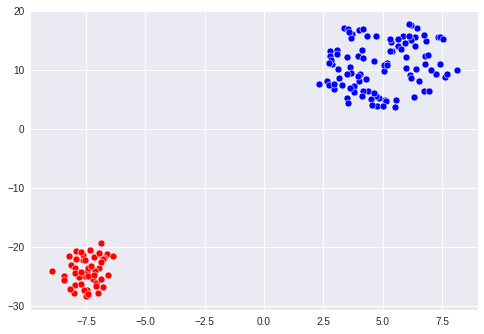

In [15]:
sns.scatterplot(tsne_data[cancer.target == -1, 0], tsne_data[cancer.target == -1, 1], color='b');
sns.scatterplot(tsne_data[cancer.target == 1, 0], tsne_data[cancer.target == 1, 1], color='r');

In [16]:
lr.fit(tsne_data, cancer.target)

LinearRegression()

In [17]:
lr.coef_

array([-0.07803407, -0.02812116], dtype=float32)

/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


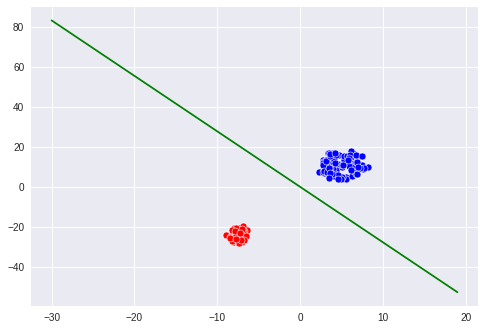

In [18]:
sns.scatterplot(tsne_data[cancer.target == -1, 0], tsne_data[cancer.target == -1, 1], color='b');
sns.scatterplot(tsne_data[cancer.target == 1, 0], tsne_data[cancer.target == 1, 1], color='r');
plt.plot(np.arange(-30, 20), -np.arange(-30, 20)*lr.coef_[0]/lr.coef_[1], c='g');

<p>Это возможно если мы дадим метки классам {-1;1} и будем тренировать алгоритм как обычно, в этом случае точки ниже линии будут отрицательного класса, а выше положительного.</p>
<p>Однако это не является лучшим выбором поскольку мы не можем сказать с какой уверенностью алгоритм дает ответ пренадлежности к тому или иному классу</p>

## Отступ

In [23]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

<p>В качестве меры уверенности, логичным решением является использование расстояние от точки до разделяющей прямой, данное расстояние называется отступом и обозначается M(x)</p>
<p>Кроме того у отступа имеется знак и он положителен если текущая точка находится на стороне своего класса и отрицателен если наоборот</p>
<p><center>$$\large{M(x_i) = [y_i == y_c]<x_iw>}$$</center></p>
<img src="./img/margin.png">
<p>Отступ показывает уверенность нашего предсказания, однако мы бы хотели опрерировать вероятностями пренадлежности класса, для этого нам необходима функция которая бы переводила значение из отрезка ($-\infty;+\infty$) в отрезок (0; 1). Так же желательно чтобы данная функция была дифференцируема, одним из лучших выборов для данных ограниченией является сигмоид функция</p>
<p><center>$$\large{\sigma = \frac{1}{1+\exp^{(-M(x))}}}$$</center></p>
<p>Так же важно что производная сигмоид функции, очень близка к нормальному распределению</p>

In [27]:
def sigmoid_deveriate(x):
    return sigmoid(x)*(1-sigmoid(x))

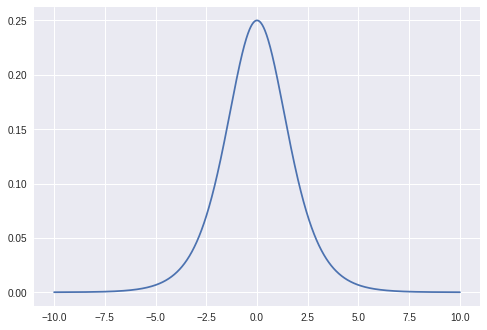

In [28]:
plt.plot(np.linspace(-10, 10, 1000), [sigmoid_deveriate(var) for var in np.linspace(-10, 10, 1000)]);

<p>Еще одним условием для построения хорошей модели линейного разделения классов, это изменение функции оптимизация с квадратичной ошибки на что-то другое</p>
<p>Наилучшим способом является оптимизации функции правдоподобия, данная функция показывает насколько ответы алгоритма правдоподобны данным</p>
<p><center>$$\large{L=\prod_{i=1}^{N}p(y_i|\sigma_i)}$$</center></p>

- $p(y_i|\sigma_i) = \sigma$ для положительного класса 
- $p(y_i|\sigma_i) = 1 - \sigma$ для отрицательного класса

<p>Недостатоком этой функции, является сложное дифференцирование, из-за произведения внутри нее, однако данная проблема легко обходится взятием логарифма, которые преобразует произведение в сумму</p>
<p><center>$$\large{L=\sum_{i=1}^{N}[y\log(\sigma)+(1-y)\log(1-\sigma)]}$$</center></p>
<p>Модель минимизирующая отступ, путем минимизации отрицательной функции логарифмического правдопобия называется логистической регрессией</p>
<p>Данная модель представленна классом LogisticRegression, в библиотеке sklearn модуля liner_models</p>
<p>Параметры модели:</p>

- penalty - регуляризация модели (l1, l2, elasticnet)
- C - сила регуляризации

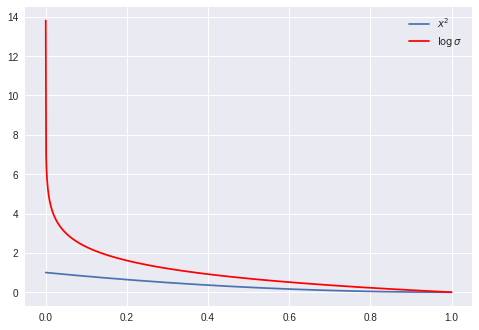

In [29]:
plt.plot(np.linspace(1e-6, 1, 1000), (1 - np.linspace(1e-6, 1, 1000))**2, label='$x^2$');
plt.plot(np.linspace(1e-6, 1, 1000), -np.log(np.linspace(1e-6, 1, 1000)), label='$\log{\sigma}$', c='r');
plt.legend();

In [30]:
lr = LogisticRegression()

In [31]:
lr.fit(tsne_data, cancer.target)

LogisticRegression()

In [32]:
tsne_data[cancer.target == -1,0]

array([2.7722983, 3.4913416, 3.09131  , 5.5450287, 3.6021144, 3.798019 ,
       3.9741862, 4.746846 , 2.8776414, 3.4842014, 5.5132413, 3.1633627,
       6.2963414, 4.0282726, 2.9409213, 2.7821448, 2.6519618, 4.359706 ,
       6.88482  , 4.853194 , 4.6216507, 4.0147805, 6.511045 , 4.28183  ,
       3.1243112, 2.8202426, 2.717017 , 4.1242437, 3.9482973, 4.711476 ,
       5.0982614, 5.119934 , 4.164931 , 6.137875 , 2.3064356, 4.1586065,
       3.087362 , 6.7280064, 2.7304628, 4.5175514, 4.1369267, 3.640403 ,
       4.615085 , 5.001592 , 3.7956793, 2.928197 , 3.2960458, 3.4834876,
       4.539243 , 3.616636 , 7.3353806, 7.2563925, 4.7252603, 5.97092  ,
       6.3414626, 4.0157223, 3.5166466, 3.709095 , 7.4227433, 6.435505 ,
       5.642618 , 6.761383 , 5.334696 , 7.6058207, 8.141241 , 6.805873 ,
       5.394534 , 6.168817 , 3.3661952, 6.9281855, 5.861875 , 7.6971464,
       3.5481846, 6.397606 , 6.3697286, 4.349744 , 5.9651117, 5.16353  ,
       6.7884636, 3.6573787, 3.5759084, 6.1176515, 

/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/imd/miniconda3/envs/mlisuct/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


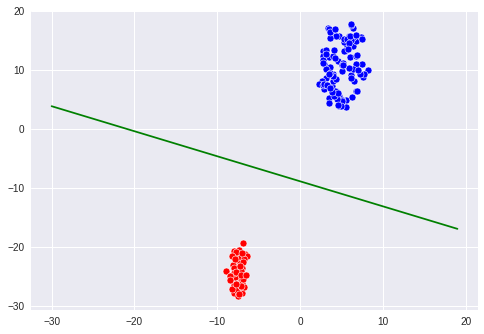

In [33]:
sns.scatterplot(tsne_data[cancer.target == -1, 0], tsne_data[cancer.target == -1, 1], color='b');
sns.scatterplot(tsne_data[cancer.target == 1, 0], tsne_data[cancer.target == 1, 1], color='r');
plt.plot(np.arange(-30, 20), (-np.arange(-30, 20)*lr.coef_[0, 0] - lr.intercept_)/lr.coef_[0, 1], c='g');